<a href="https://colab.research.google.com/github/lampedepoche/ML-NN---Final-project/blob/main/Imputation_missing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install miceforest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import miceforest as mf
from miceforest import ImputationKernel
from miceforest import mean_match_shap

from scipy.stats import anderson, jarque_bera

import random

# DOWNLOAD DATA



In [ ]:
# For Google Colab purposes
from google.colab import files
uploaded = files.upload()

dtypes = {
    "subjectID": "Int64",
    "group_number": "Int64",
    "condition": "category",
    "gender": "category",
    "Synchrony1_with": "Int64",
    "Synchrony2_with": "Int64"
}
columns_selected=['Psychometric', 'subjectID', 'group_number', 'condition', 'Age', 'gender', 'SPIN', 'IRI', 'EC', 'cohesion',
                  'Collective_Efficacy', 'trust', 'Group_CCF_I_Mean', 'SPIN_mean', 'cohesion_mean', 'Collective_Efficacy_mean',
                  'HR', 'RSA', 'RMSSD', 'Synchrony1_with', 'Synchrony1', 'Synchrony2_with', 'Synchrony2', 'Average_Synchrony']

#loading data, saving original for further use if needed
data = pd.read_csv('Music.csv', dtype=dtypes, usecols=columns_selected)
df=pd.DataFrame(data)
# Replace number by explicit string for categorical data
df['condition'].replace({'4': 'synchronous', '5': 'asynchronous'}, inplace=True)
df['gender'].replace({'1' : 'man', '2': 'woman'}, inplace=True)
# Save
df_original = df.copy()
# Display
df.describe()

Saving Music.csv to Music.csv


,Psychometric,subjectID,group_number,Age,SPIN,IRI,EC,cohesion,Collective_Efficacy,trust,...,cohesion_mean,Collective_Efficacy_mean,HR,RSA,RMSSD,Synchrony1_with,Synchrony1,Synchrony2_with,Synchrony2,Average_Synchrony
count,152.000000,153.0,153.0,152.000000,152.000000,111.000000,152.000000,152.000000,152.000000,152.000000,...,153.000000,153.000000,141.000000,141.000000,141.000000,138.0,138.000000,136.0,136.000000,136.000000
mean,646.901316,178.117647,1026.0,22.539474,1.481037,3.458494,3.465147,4.399123,4.351974,4.979532,...,4.395425,4.346405,81.012554,6.033535,37.972327,182.978261,0.169529,209.117647,29.545400,14.857398
std,45.040638,45.536992,14.767942,2.063982,0.894440,0.372947,0.549144,1.108559,1.017380,0.940936,...,0.700063,0.606609,12.118870,0.955771,19.518240,44.708377,0.206288,144.74023,169.384397,84.696363
min,540.000000,101.0,1001.0,18.000000,0.000000,2.321429,1.857143,1.000000,2.000000,2.111111,...,2.888889,3.166667,51.437056,2.981144,6.013631,101.0,-0.411733,101.0,-0.411733,-0.332110
25%,616.500000,139.0,1013.0,21.000000,0.882353,3.214286,3.133333,3.666667,3.750000,4.333333,...,3.888889,3.833333,73.545214,5.427172,23.383638,142.5,0.088239,146.75,0.084223,0.032667
50%,642.500000,177.0,1026.0,22.000000,1.352941,3.464286,3.466667,4.666667,4.250000,4.944444,...,4.444444,4.250000,79.731207,6.092003,33.592107,184.5,0.213978,189.5,0.220645,0.218551
75%,682.000000,218.0,1039.0,24.000000,1.882353,3.660714,3.857143,5.000000,5.062500,5.666667,...,4.777778,4.833333,87.438137,6.745884,46.057097,221.75,0.313634,226.25,0.322069,0.296283
max,752.000000,256.0,1051.0,32.000000,3.882353,4.464286,4.733333,6.000000,7.000000,7.000000,...,5.555556,5.500000,125.192620,8.112115,115.565763,256.0,0.695096,999.0,999.000000,499.631376


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Psychometric              152 non-null    float64 
 1   subjectID                 153 non-null    Int64   
 2   group_number              153 non-null    Int64   
 3   condition                 153 non-null    category
 4   Age                       152 non-null    float64 
 5   gender                    153 non-null    category
 6   SPIN                      152 non-null    float64 
 7   IRI                       111 non-null    float64 
 8   EC                        152 non-null    float64 
 9   cohesion                  152 non-null    float64 
 10  Collective_Efficacy       152 non-null    float64 
 11  trust                     152 non-null    float64 
 12  Group_CCF_I_Mean          141 non-null    float64 
 13  SPIN_mean                 153 non-null    float64 

# DATA PREPROCESSING & EXPLORATION OF MISSING DATA

In [ ]:
df_cleaned = df.copy()

## Ensure that every missing data is encoded as nan

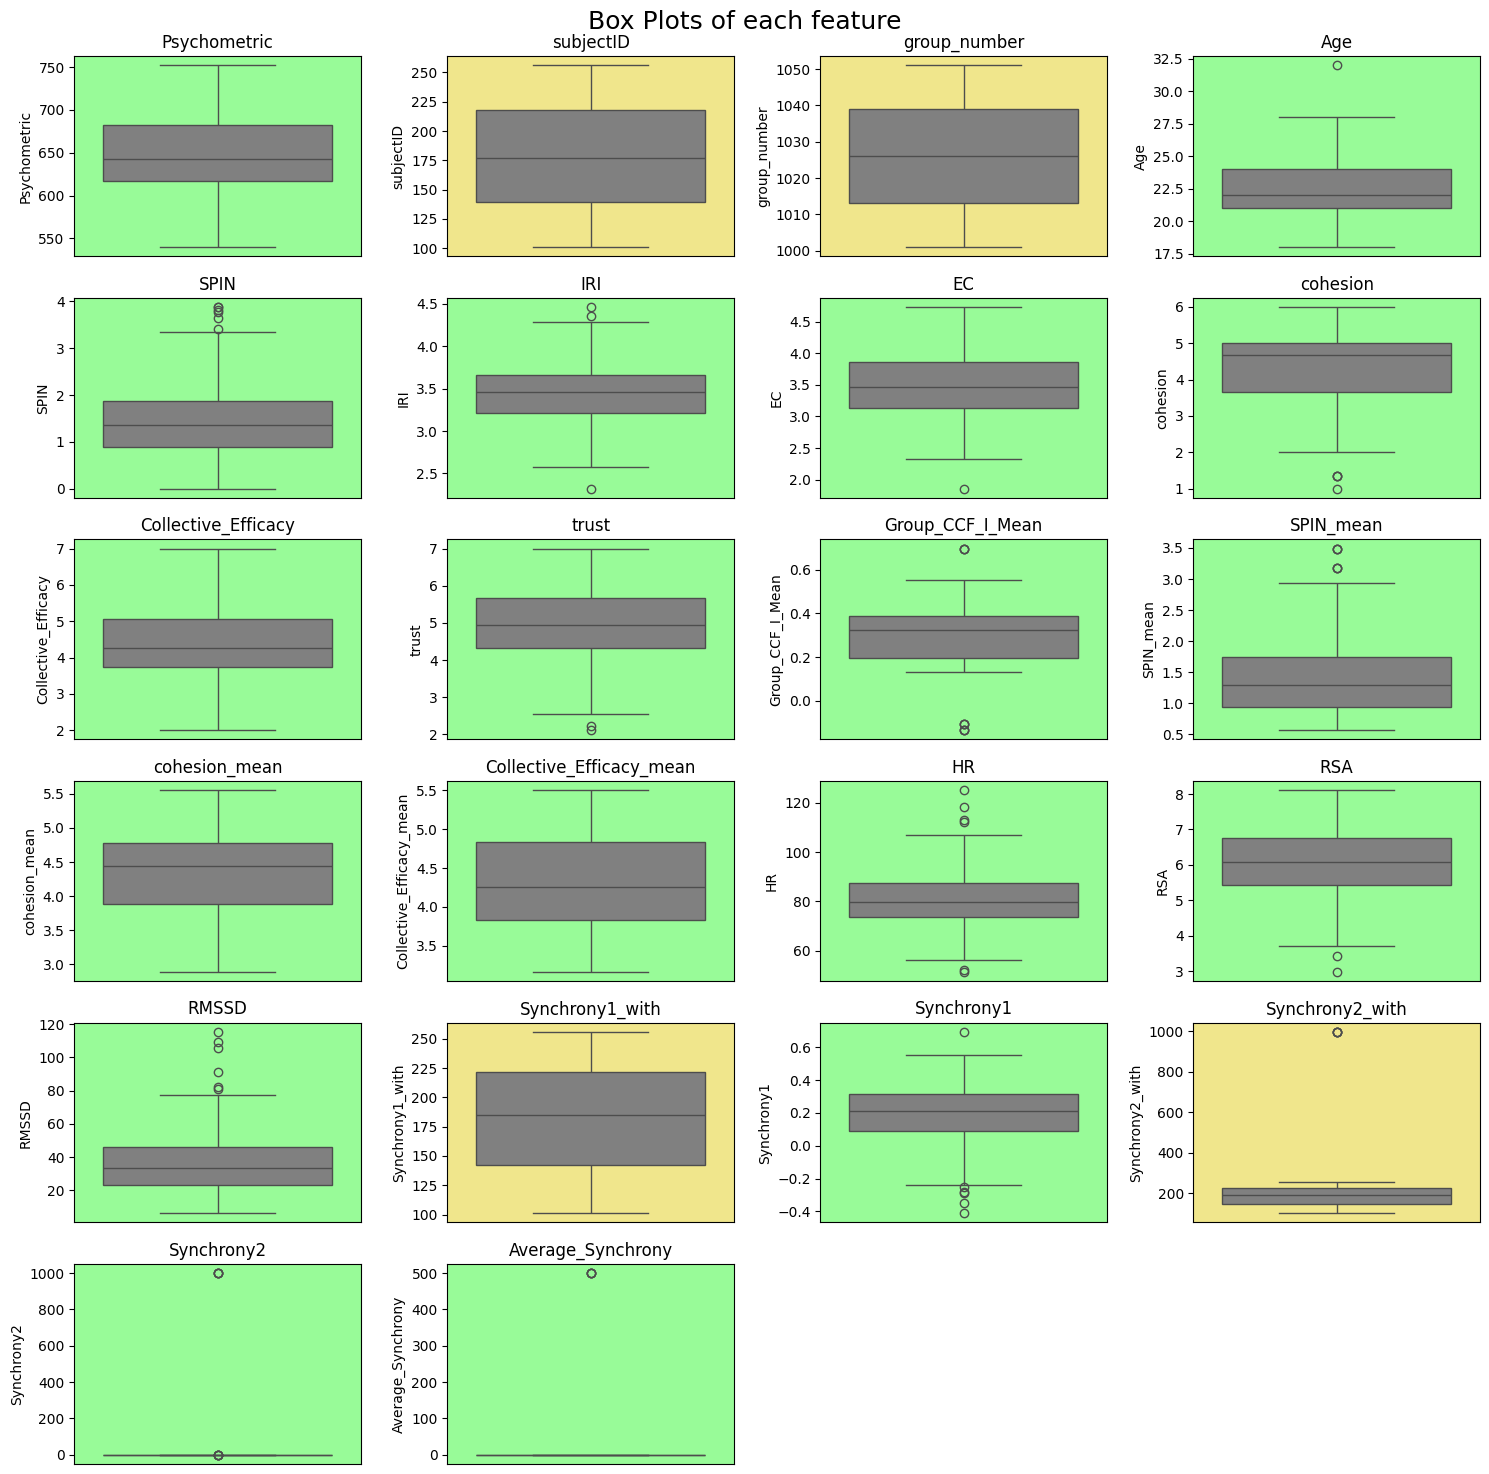

In [ ]:
# To plot
no_string_columns = df_cleaned.drop(['condition','gender'], axis=1).columns

# Set two different colors between continuous and categorical variables
colors = {'float64': '#98FB98', 'Int64': '#F0E68C'}

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 15))

# Create one boxplot per feature in a subplot
for (column, ax) in zip(no_string_columns, axes.flatten()):
    data_type = str(df_cleaned[column].dtype) # get the datatype of the feature
    # Seaborn boxplot does not handle missing data on integers
    if data_type == 'Int64':
      sns.boxplot(df_cleaned[column].astype(float), ax=ax, color='gray')
    else:
      sns.boxplot(df_cleaned[column], ax=ax, color='gray')
    ax.set_title(column)
    # Some lines for enhanced visual impact
    ax.set_facecolor(colors.get(data_type, 'gray'))  # background color
    ax.set_xticks([]) # no x-axis
    ax.tick_params(axis='y', labelsize=10) # reduce size of letters in y-axis

# Remove two last empty subplots
for i in range(22, 24):
    fig.delaxes(axes.flatten()[i])

fig.suptitle('Box Plots of each feature', fontsize=18)
plt.tight_layout()
plt.show()

About categorical variables:
- `Synchrony2_with` represents the IDs of partner participants, and so shouldn't go beyond the ID of the last participant (= 256). Values close to 1000 are likely to represent missing data (= 999).

For continuous variables:
- `Synchrony2`'s boxplot highlights values that are outliers. Again, these are probably the result of missing values (= 999).
- The same applies to `Average_Synchrony`, which shows outliers around 500, corresponding to the average between a value of around 1 and an outlier of 999.

All these outliers will therefore be treated as missing values by the code below.

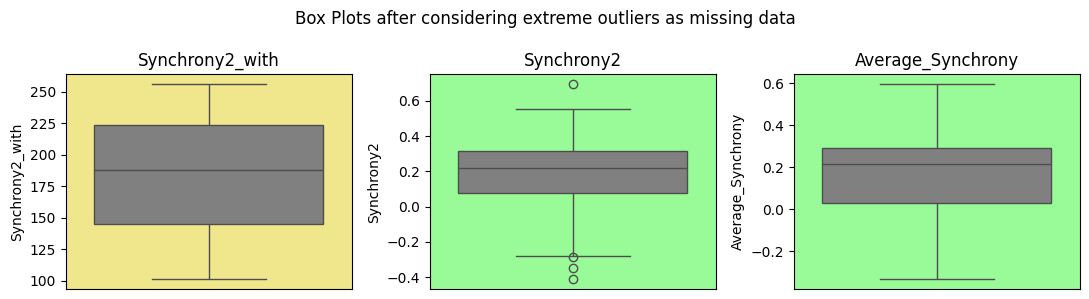

In [ ]:
# Convert value=999 into missing value
df_cleaned['Synchrony2_with'] = pd.to_numeric(df_cleaned['Synchrony2_with'], errors='coerce') # need to change data type to float
df_cleaned.replace(999, np.nan, inplace=True)
df_cleaned['Synchrony2_with'] = df_cleaned['Synchrony2_with'].astype('Int64') # Back to integer data type

# Convert Average_Synchony>100 into missing value
df_cleaned['Average_Synchrony'] = np.where(df_cleaned['Average_Synchrony'] > 100, np.nan, df_cleaned['Average_Synchrony'])


# Plot the results
column_to_plot = ['Synchrony2_with', 'Synchrony2', 'Average_Synchrony']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 3))

# Create one boxplot per feature in a subplot
for i, (column, ax) in enumerate(zip(column_to_plot, axes.flatten())):
    data_type = str(df_cleaned[column].dtype) # get the datatype of the feature
    # Seaborn boxplot does not handle missing data on integers
    if data_type == 'Int64':
      sns.boxplot(df_cleaned[column].astype(float), ax=ax, color='gray')
    else:
      sns.boxplot(df_cleaned[column], ax=ax, color='gray')
    ax.set_title(column)
    # Some lines for enhanced visual impact
    ax.set_facecolor(colors.get(data_type, 'gray'))  # background color
    ax.set_xticks([]) # no x-axis

fig.suptitle('Box Plots after considering extreme outliers as missing data')
plt.tight_layout()
plt.show()

## Consider averages based on only two data values as missing data

In [ ]:
missing_SPIN = data['SPIN'].isnull().sum()
missing_SPIN_mean = data['SPIN_mean'].isnull().sum()
missing_cohesion = data['cohesion'].isnull().sum()
missing_cohesion_mean = data['cohesion_mean'].isnull().sum()
missing_Collective_Efficacy = data['Collective_Efficacy'].isnull().sum()
missing_Collective_Efficacy_mean = data['Collective_Efficacy_mean'].isnull().sum()

print(f'{missing_SPIN} missing data for the SPIN feature and               ',
      f'{missing_SPIN_mean} missing data for the SPIN_mean feature.')
print(f'{missing_cohesion} missing data for the cohesion feature and           ',
      f'{missing_cohesion_mean} missing data for the cohesion_mean feature.')
print(f'{missing_Collective_Efficacy} missing data for the Collective_Efficacy feature and',
      f'{missing_Collective_Efficacy_mean} missing data for the Collective_Efficacy_mean feature.')

1 missing data for the SPIN feature and                0 missing data for the SPIN_mean feature.
1 missing data for the cohesion feature and            0 missing data for the cohesion_mean feature.
1 missing data for the Collective_Efficacy feature and 0 missing data for the Collective_Efficacy_mean feature.


The code above reveals that these three group mean features are calculated from just two values, as the third is missing. Consequently, these incorrect means should be considered as missing data.


In [ ]:
def delete_mean_values(single_var, mean_var):
  no_group_number = df_cleaned.loc[df_cleaned[single_var].isnull(), 'group_number'].unique()
  df_cleaned.loc[df_cleaned['group_number'].isin(no_group_number), mean_var] = np.nan

In [ ]:
# Missing data in SPIN, cohesion and Collective_Efficacy
delete_mean_values('SPIN', 'SPIN_mean')
delete_mean_values('cohesion', 'cohesion_mean')
delete_mean_values('Collective_Efficacy', 'Collective_Efficacy_mean')

## Visualize missing data

In [ ]:
# Calculate the percentage of missing data in the dataset
total_missing = df_cleaned.isnull().sum().sum()
total_cells = df_cleaned.size
percentage_missing = (total_missing / total_cells) * 100
print(f'{percentage_missing:.2f}% of the data values are missing.')

# Calculate the percentage of participants with any missing data
participants_missing = df_cleaned.isnull().any(axis=1).sum()
percentage_participants_missing = (participants_missing / len(df_cleaned)) * 100
print(f'And {percentage_participants_missing:.2f}% of participants have missing data.\n')

# Order the features by percentage of missing value
df_cleaned.isnull().mean().sort_values(ascending=False)

5.42% of the data values are missing.
And 44.44% of participants have missing data.



IRI                         0.274510
Average_Synchrony           0.137255
Synchrony2                  0.137255
Synchrony2_with             0.137255
Synchrony1                  0.098039
Synchrony1_with             0.098039
HR                          0.078431
RMSSD                       0.078431
RSA                         0.078431
Group_CCF_I_Mean            0.078431
SPIN_mean                   0.019608
cohesion_mean               0.019608
Collective_Efficacy_mean    0.019608
Collective_Efficacy         0.006536
trust                       0.006536
cohesion                    0.006536
EC                          0.006536
SPIN                        0.006536
Age                         0.006536
Psychometric                0.006536
subjectID                   0.000000
gender                      0.000000
condition                   0.000000
group_number                0.000000
dtype: float64

The overall prevalence of missingness is low (5.42% missing). However, the majority of features have missing data (20 out of 24 features:):
- `IRI` (27.5% missing)
- `Average_Synchrony`, `Synchrony2`, and `Synchrony2_with` (13.7% missing)
- `Synchrony1` and `Synchrony1_with` (9.8% missing)
- `HR`, `RMSSD`, `RSA`, and `Group_CCF_I_Mean` (7.8% missing)
- `SPIN_mean`, `cohesion_mean`, and `Collective_Efficacy_mean` (1.96% missing)
- `Collective_Efficacy`, `trust`, `cohesion`, `EC`, `SPIN`, `Age`, and `Psychometric` (0.7% missing).

In addition, 44.44% of participants have at least one missing value, making the simple removal of participants with no missing data very complicated, and with a high risk of significant loss of information on such a small dataset.

<Axes: >

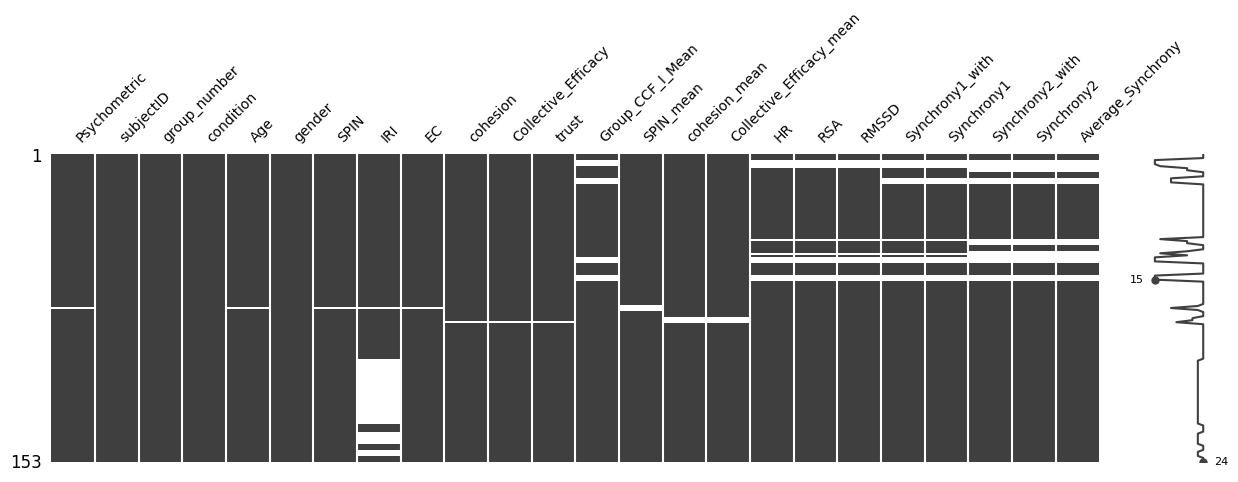

In [ ]:
# Plot of missing data for the entire dataset
msno.matrix(df_cleaned, figsize=(15,4), fontsize=10)

There are several streaks of missingness most notably in the IRI variable.

---



In [ ]:
df_cleaned.columns

Index(['Psychometric', 'subjectID', 'group_number', 'condition', 'Age',
       'gender', 'SPIN', 'IRI', 'EC', 'cohesion', 'Collective_Efficacy',
       'trust', 'Group_CCF_I_Mean', 'SPIN_mean', 'cohesion_mean',
       'Collective_Efficacy_mean', 'HR', 'RSA', 'RMSSD', 'Synchrony1_with',
       'Synchrony1', 'Synchrony2_with', 'Synchrony2', 'Average_Synchrony'],
      dtype='object')

<Axes: >

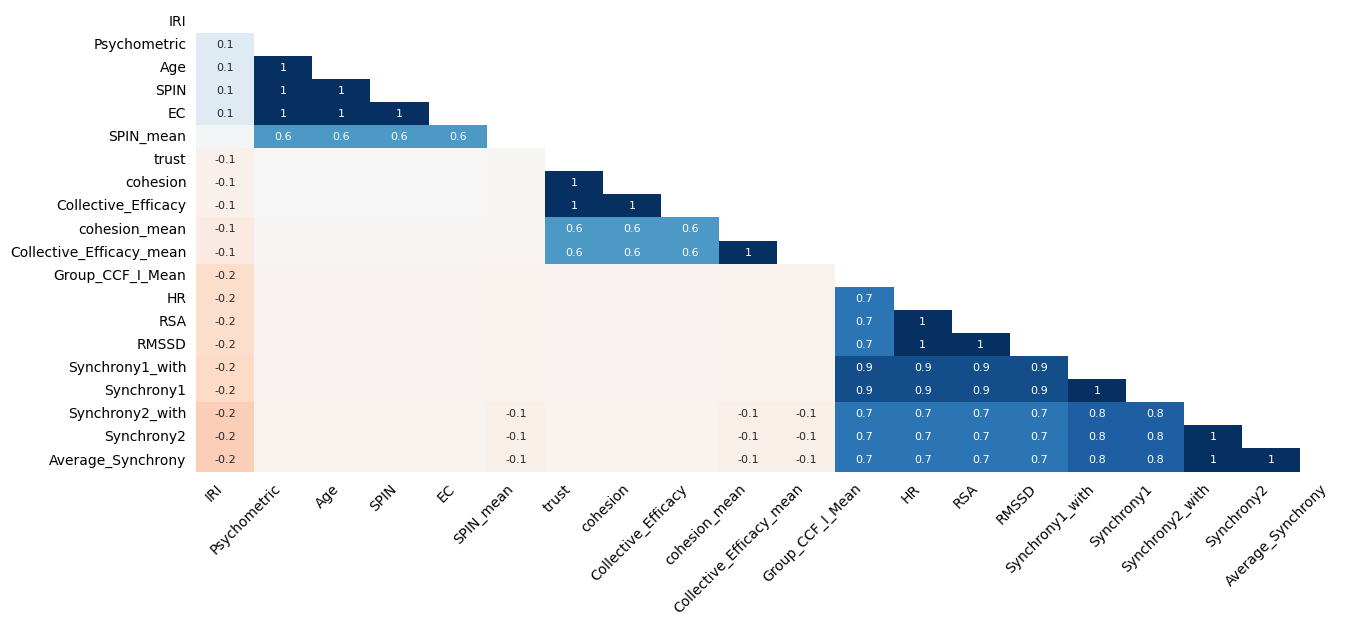

In [ ]:
# Correlation matrix of missing data
reorganized_columns=['IRI',
                     'Psychometric', 'Age', 'SPIN', 'EC', 'SPIN_mean',
                     'trust', 'cohesion', 'Collective_Efficacy',
                     'cohesion_mean', 'Collective_Efficacy_mean',
                     'Group_CCF_I_Mean', 'HR', 'RSA', 'RMSSD',
                     'Synchrony1_with', 'Synchrony1', 'Synchrony2_with', 'Synchrony2', 'Average_Synchrony',
                     'subjectID', 'group_number', 'condition', 'gender',
                     ]
msno.heatmap(df_cleaned[reorganized_columns], figsize=(15,6), fontsize=10, cbar=False)

Missing values co-occur for most features, with the exception of `IRI`.

<Axes: >

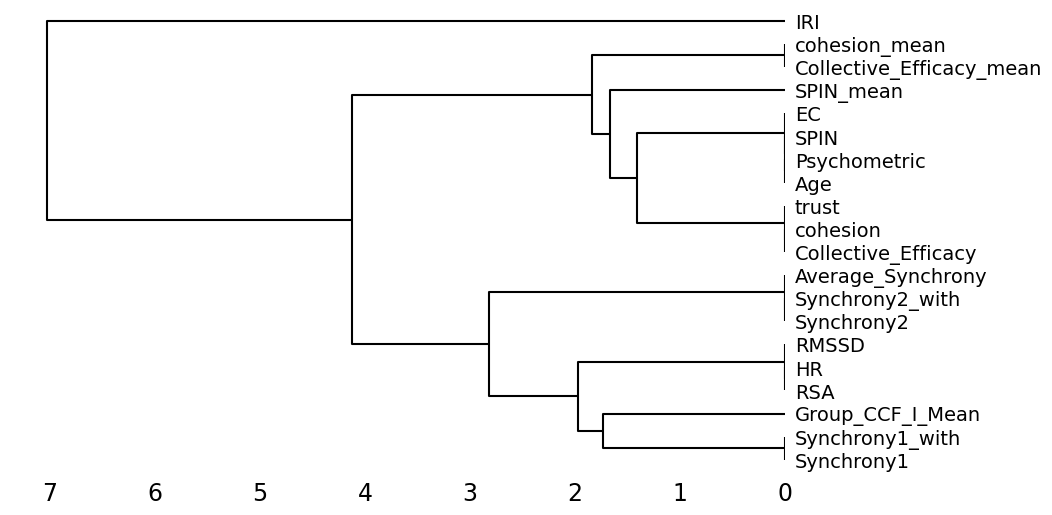

In [ ]:
# Dendrogram presenting clusters of missing data between features
complete_features = ['group_number', 'subjectID', 'condition', 'gender']
msno.dendrogram(df_cleaned.drop(complete_features, axis=1), figsize=(10,6), fontsize=14, orientation='left')

The dendrogram groups the features with co-occurring missing data.
- The `IRI` feature is on a single cluster, so it can be considered MCAR (Missing At Random) since there seems to be no relationship between its missing data and that of another feature. A likely hypothesis would be that the last participants did not have access to the IRI test, but this is not due to any of their specificities.
- `EC`, `SPIN`, `Psychometric`, and `Age` are part of the same cluster of level 0, which means that their missing data perfectly co-occur. However, only one value is missing per feature. For this reason, we also consider these data as MAR.
- `trust`, `cohesion`, and `Collective_Efficacy` also have a single missing co-occurrence, so these features can also be considered as MAR.
- `SPIN_mean`, `cohesion_mean`, and `Collective_Efficacy_mean` also have a single missing co-occurrence (since one value is actually repeated three times), so these features can also be considered as MAR.
- `Average_Synchrony`, `Synchrony2`, `Synchrony2_with`, `Synchrony1`, `Synchrony1_with`, `HR`, `RMSSD`, `RSA`, and `Group_CCF_I_Mean` present a high correlation between their missing data. The randomness of these missing data may then be more delicate to assume. However, by examining at the relationship between these features we discover that `HR`, `RMSSD`, and `RSA` values are necessary for calculating the value of `Group_CCF_I_Mean` and the Synchrony. We also need the values of `Synchrony1` and `Synchrony2` to obtain the value of `Average_Synchrony`. Finally, `Synchrony1_with` and `Synchrony2_with` are simply ID indicating with which participant the synchrony is calculated. In fact, it is quite likely that the physiological recordings of `HR`, `RMSSD`, and `RSA` were of poor quality for some participants, resulting in a chain reaction in the recording of other depending variables. Thus, it seems unlikely to us that the missing values hide a specific pattern of an unobserved feature. That's why, thanks to all this information, we can retain the MAR assumption for these data.

The categorization of features as MCAR, MAR, or MNAR was based on Stef Van Buuren's book (_Flexible Imputation of Missing Data Second Edition_, 2018, Chapter 1.2 Concepts of MCAR, MAR and MNAR).

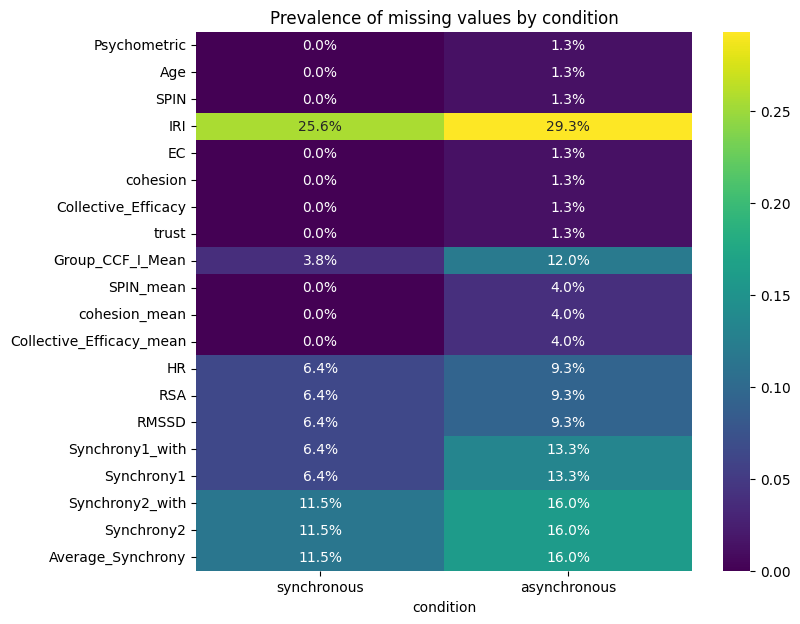

In [ ]:
# Create a df of True/False "the value is missing"
missing_data = df_cleaned.drop(complete_features, axis=1).isnull()

# Add the column of the condition
missing_data['condition'] = df_cleaned['condition']

# Create a heatmap of missing data in each condition
plt.figure(figsize=(8, 7))
sns.heatmap(missing_data.groupby('condition').mean().T, cmap="viridis", annot=True, fmt=".1%")
plt.title('Prevalence of missing values by condition')
plt.show()

In general, there is more missing data in the asynchronous condition than in the synchronous condition. Yet the experimental condition most likely has an impact on synchrony between participants in the same group. This is why, to preserve the maximum amount of information and balance in the data, the imputation of missing data may prove interesting. <br>
With missing data that respects the MAR assumption, Multiple Imputation by Chained Equation (MICE) is suitable for our case. Although the exactitude of the imputation is not easily verifiable, complete case analysis is not a problem-free solution. Indeed according to Azur et al. (2011), complete case analysis "relies upon stronger missing data assumptions than multiple imputation and it can result in biased estimates".

# MULTIPLE IMPUTATION BY CHAINED EQUATIONS (MICE)
The first imputation trial (presented in class) consisted of comparing different iterative imputations on a part of the dataset (the only complete part) to which missing data had been artificially created. The calculation of the MSE between the imputed data and the real data was decisive for the imputation model chosen. However, after lengthy research, it turned out that this is not the best way to assess the relevance of an imputation, especially on a small dataset like ours. It's better to impute the data and tune the parameters using the miceforest library (which has shown good results). Once this has been done, diagnostic plots will help us assess the likelihood of the imputations. The parameters chosen are mainly taken from articles (Azur et al., 2011, Austing et al., 2021) and from the GitHub page of the miceforest library: https://github.com/AnotherSamWilson/miceforest.

According to Azur et al. (2011), when imputing a feature that is the result of a calculation between two other observed features, it is preferable to impute these first two features and then calculate the value of the last one. "Von Hippel refers to this approach as “impute, then transform.”" (Austin et al., 2021).

Our dataset is in a three-level hierarchical format (individual, duo, trio features). For simplicity, two levels of imputation (individual and duo), with corresponding data wrangling, will be implemented successively. According to Austin et al. (2011), all other features (that represent individual or group variables) must be retained for imputations to reduce bias. Nevertheless, only imputations corresponding to the hierarchical level will be retained.µ

## Individual features
`[Psychometric, Age, SPIN, IRI, EC, cohesion, Collective_Efficacy, trust, HR, RSA, RMSSD]`

### Settings
"The number of imputed data sets should be at least as large as the percentage of subjects with any missing data" (Austin et al., 2021).
"Standard software uses 5 to 20 cycles by default, and it is rarely necessary to increase these values" (Austin et al., 2021).

In [ ]:
print(f'As a reminder: {percentage_participants_missing:.2f}% of participants have missing data.\n')

As a reminder: 44.44% of participants have missing data.



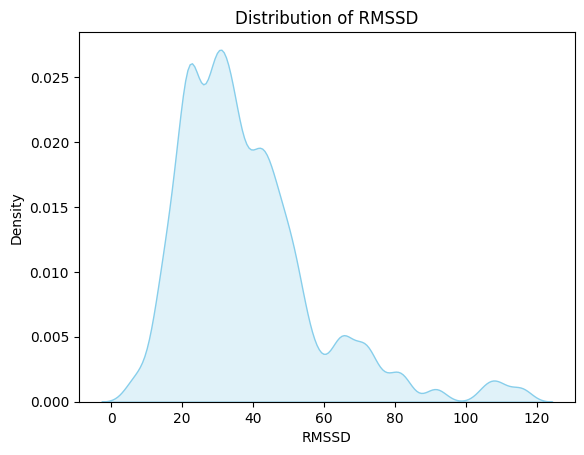

In [ ]:
# Density curve of the target Synchrony
sns.kdeplot(df_cleaned['RMSSD'], fill=True, color='skyblue', bw_method=0.15)

plt.title(f'Distribution of RMSSD')
plt.xlabel('RMSSD')
plt.ylabel('Density')
plt.show()

In [ ]:
# Normality test of Jarque-Bera
jb_statistic, p_value = jarque_bera(df_cleaned['RMSSD'].dropna())
# Display the results
print(f"Test statistic: {jb_statistic:.4f}")
print(f"       p-value: {p_value:.4}")

# Interprétation des résultats
if p_value < 0.05:
    print("-> Rejection of the null hypothesis: the distribution is not normal.")
else:
    print("-> No rejection of the null hypothesis: the distribution is normal.")

Test statistic: 97.2623
       p-value: 7.582e-22
-> Rejection of the null hypothesis: the distribution is not normal.


Knowing that the distribution of `RMSSD` is most likely skewed, it will be necessary to perform Multiple imputation for continuous variables with the use of predictive-mean matching (PMM) (Austin et al., 2021).

For this PMM, "Morris et al. suggest that identifying the 10 closest subjects without missing data performs well" (Austin et al, 2021).

In [ ]:
num_datasets=45   # rule of thumb of percentage of particiants with any missing data
num_iterations=13 # average number between 5 and 20
num_candidates=10 # number of optimal closest subjects

### MICE Forest implementation

In [ ]:
# Remove ID features
imputation_df_1  = df_cleaned.drop(['group_number', 'subjectID', 'Synchrony1_with', 'Synchrony2_with'], axis=1)
indiv_features = ['Psychometric', 'Age', 'SPIN', 'IRI', 'EC', 'cohesion', 'Collective_Efficacy', 'trust', 'HR', 'RSA', 'RMSSD']

In [ ]:
# Set up the PMM
scheme_mmc = mean_match_shap.copy()
scheme_mmc.set_mean_match_candidates(num_candidates)

# Create kernel
kernel_meanmatch_indiv = mf.ImputationKernel(
                              imputation_df_1,
                              variable_schema=indiv_features,
                              mean_match_scheme=scheme_mmc,
                              datasets=num_datasets,
                              save_all_iterations=True,
                              random_state=456,
                              )

# Tune the parameters
optimal_parameters_indiv, losses = kernel_meanmatch_indiv.tune_parameters(
                                            dataset=22, # a random dataset
                                            variables=indiv_features,
                                            nfold=10,
                                            verbose=True,
                                            random_state=456
                                          )

Initialized logger with name tune: 5
Psychometric | 0 - 1 - 2 - 3 - 4 - 
Age | 0 - 1 - 2 - 3 - 4 - 
SPIN | 0 - 1 - 2 - 3 - 4 - 
IRI | 0 - 1 - 2 - 3 - 4 - 
EC | 0 - 1 - 2 - 3 - 4 - 
cohesion | 0 - 1 - 2 - 3 - 4 - 
Collective_Efficacy | 0 - 1 - 2 - 3 - 4 - 
trust | 0 - 1 - 2 - 3 - 4 - 
HR | 0 - 1 - 2 - 3 - 4 - 
RSA | 0 - 1 - 2 - 3 - 4 - 
RMSSD | 0 - 1 - 2 - 3 - 4 - 


In [ ]:
# Display the best parameters and losses per feature
for col in [0, 2, 4, 5,  6, 7, 8, 9, 14, 15, 16]:
  print(imputation_df_1.columns[col])
  print(optimal_parameters_indiv[col])
  print(f'Average out of fold cross-validation loss: {losses[col]}\n')

Psychometric
{'boosting': 'gbdt', 'num_iterations': 48, 'max_depth': 8, 'num_leaves': 12, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.2569616425857437, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.8373938993558562, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'learning_rate': 0.02, 'cat_smooth': 23.012249391696812}
Average out of fold cross-validation loss: 1961.3903594996052

Age
{'boosting': 'gbdt', 'num_iterations': 88, 'max_depth': 8, 'num_leaves': 24, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.7905943053219288, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.8842086666525363, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'learning_rate': 0.02, 'cat_smooth': 7.664956899528772}
Average out of fold cross-validation loss: 3.550759566221177

SPIN
{'boosting': 'gbdt', 'num_iterations': 121, 'max_depth': 8, 'num_leaves':

In [ ]:
# Run the MICE algorithm
kernel_meanmatch_indiv.mice(iterations=num_iterations,
                            variable_parameters=optimal_parameters_indiv,
                            verbose=True
)

Initialized logger with name mice 1-13
Dataset 0
1  | Psychometric | Collective_Efficacy | cohesion | EC | trust | SPIN | Age | HR | RSA | RMSSD | IRI
2  | Psychometric | Collective_Efficacy | cohesion | EC | trust | SPIN | Age | HR | RSA | RMSSD | IRI
3  | Psychometric | Collective_Efficacy | cohesion | EC | trust | SPIN | Age | HR | RSA | RMSSD | IRI
4  | Psychometric | Collective_Efficacy | cohesion | EC | trust | SPIN | Age | HR | RSA | RMSSD | IRI
5  | Psychometric | Collective_Efficacy | cohesion | EC | trust | SPIN | Age | HR | RSA | RMSSD | IRI
6  | Psychometric | Collective_Efficacy | cohesion | EC | trust | SPIN | Age | HR | RSA | RMSSD | IRI
7  | Psychometric | Collective_Efficacy | cohesion | EC | trust | SPIN | Age | HR | RSA | RMSSD | IRI
8  | Psychometric | Collective_Efficacy | cohesion | EC | trust | SPIN | Age | HR | RSA | RMSSD | IRI
9  | Psychometric | Collective_Efficacy | cohesion | EC | trust | SPIN | Age | HR | RSA | RMSSD | IRI
10  | Psychometric | Collective_E

In [ ]:
# Display the settings
kernel_meanmatch_indiv


              Class: ImputationKernel
           Datasets: 45
         Iterations: 13
       Data Samples: 153
       Data Columns: 20
  Imputed Variables: 11
save_all_iterations: True

### Diagnostic plotting

In [ ]:
# Choose randomly 15 datasets to displays
datasets_display = [i for i in range(0, 45, 3)]

# Individual characteristics with the most missing data
columns_to_plot = ['IRI', 'HR', 'RSA', 'RMSSD']

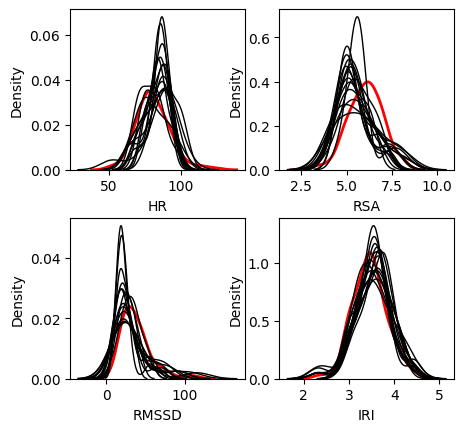

In [ ]:
# Distribution of the imputations per features
kernel_meanmatch_indiv.plot_imputed_distributions(datasets=datasets_display, variables=columns_to_plot, hspace=0.3, left=0.3)

The distributions of the IRI feature (15 black lines) show a nice shape very close to the distribution of non-missing data (red line).
On another note, the distribution of imputations of HR, RMSSD and RSA features, deviate more from the distribution of actual data:
- HR: the imputations seem in general to be more negatively skewed
- RSA: the imputations seem in general to be more positively skewed.
- RMSSD: the imputations seem to be more concentrated around the mode.


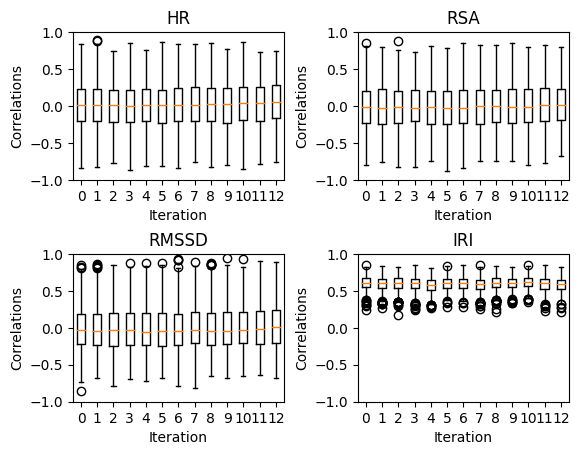

In [ ]:
# Correlations between the 45 imputation datasets
kernel_meanmatch_indiv.plot_correlations(variables=columns_to_plot, wspace=0.35, hspace=0.5)

The representations of the correlations between the 45 imputation datasets are not really encouraging. Indeed, apart from the IRI imputations, the various imputations of each value do not appear to be correlated. What's more, no improvement in correlation is visible across iterations for HR, RMSSD, and RSA features.

### Mean aggregation of all the datasets

In [ ]:
# Aggregate all the datasets by the mean
sum_df = kernel_meanmatch_indiv.complete_data(0)[indiv_features]
for i in range(1, 45):
  sum_df = sum_df + kernel_meanmatch_indiv.complete_data(i)[indiv_features]
imputed_df_indiv = sum_df/45

# Complete the imputed dataset
df_imputed = df_cleaned.copy()
for col in indiv_features:
  # Impute only the missing data of the individual features
  df_imputed[col] = df_cleaned[col].combine_first(imputed_df_indiv[col])

<Axes: >

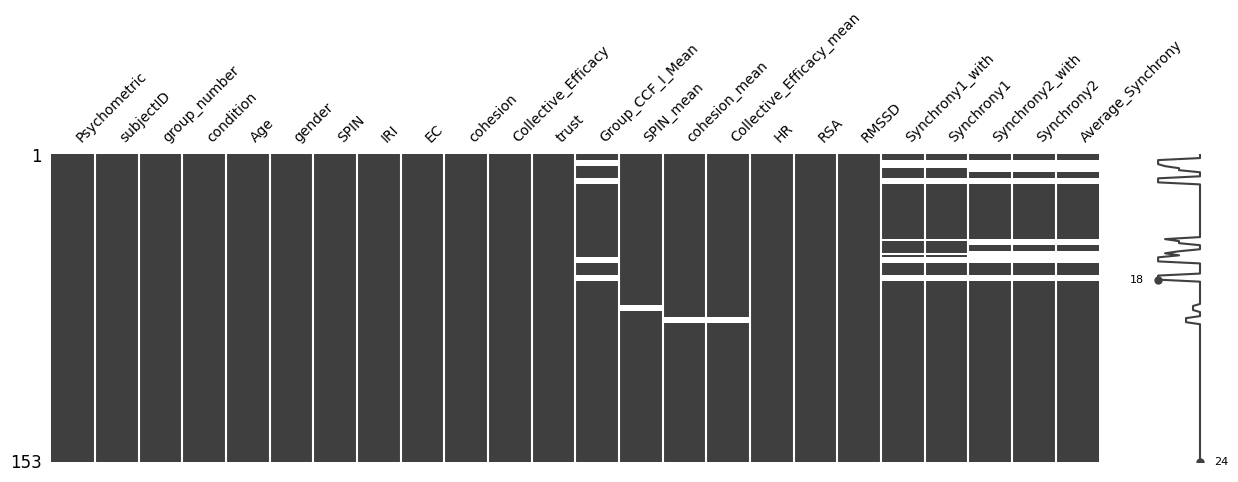

In [ ]:
msno.matrix(df_imputed, figsize=(15,4), fontsize=10)

## Complete mean features

In [ ]:
# Calculate the three group mean based on the new imputed data
mean_features = ['SPIN_mean', 'cohesion_mean', 'Collective_Efficacy_mean']
single_features = ['SPIN', 'cohesion', 'Collective_Efficacy']
for (mean_col, value_col) in zip(mean_features, single_features):
  # Identify the first index of missing data in mean_col
  idx = df_imputed[mean_col].isnull().idxmax()
  mean_imputed = df_imputed[value_col].iloc[idx:idx+3].mean()
  # Replace missing data with the mean of 'value_col' values
  df_imputed.loc[idx, mean_col] = mean_imputed
  df_imputed.loc[idx+1, mean_col] = mean_imputed
  df_imputed.loc[idx+2, mean_col] = mean_imputed

<Axes: >

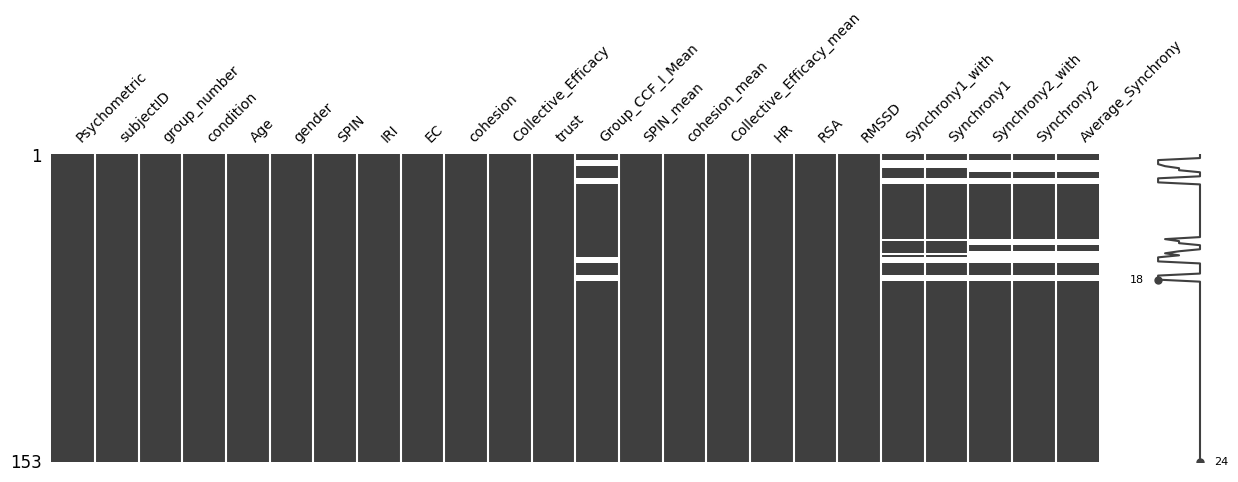

In [ ]:
msno.matrix(df_imputed, figsize=(15,4), fontsize=10)

## Group features
`[Synchrony1, Synchrony2, Group_CCF_I_Mean]`

### Data-wrangling
The aim is to create a tidy dataset, where one row represents one observation. The focus is the synchrony that results from the interaction between two people and their characteristics.

In [ ]:
# Check condition: no duplicates or omissions in subjectID
diff_ID = df_imputed['subjectID'].diff()
if all(diff_ID[1:].eq(1)):
  print('The column `subjectID` contains a sequence of integers where each subsequent element is equal to the previous element + 1')
else:
  print('The column `subjectID` does not contain a sequence of ommission-free integers.')

# Check group numbering is correct
diff_groups = df_imputed['subjectID'].diff()
group_of_3 = (diff_groups[1] == diff_groups[2])
for i in range(3, len(df_cleaned), 3):
  group_of_3 = (diff_groups[i] == 1 and diff_groups[i+1] == diff_groups[i+2])
if group_of_3:
  print('Each group has its own unique ID number and is made up of three participants.')

The column `subjectID` does not contain a sequence of ommission-free integers.
Each group has its own unique ID number and is made up of three participants.


It's important to bear in mind that not all participant IDs are consecutive.

In [ ]:
def synchrony_reorganization(idx, partner_id, old_df, new_df):
    # Assign the id of the partner if exits, -1 if nan
    part_sync1 = old_df['Synchrony1_with'].iloc[idx] if not pd.isna(old_df['Synchrony1_with'].iloc[idx]) else -1
    part_sync2 = old_df['Synchrony2_with'].iloc[idx] if not pd.isna(old_df['Synchrony2_with'].iloc[idx]) else -1

    # Search if the partner ID is related to the Synchrony1 value
    if partner_id == part_sync1:
        new_df.loc[idx, 'Synchrony1'] = old_df['Synchrony1'].iloc[idx]
    # or related to the Synchrony2 value
    elif partner_id == part_sync2:
        new_df.loc[idx, 'Synchrony1'] = old_df['Synchrony2'].iloc[idx]
    # if it doesnt' exist: it's a missing data
    else:
        new_df.loc[idx, 'Synchrony1'] = np.nan

def partnerID_reorganization(old_df, new_df):
  # Reorganization of the ID and the synchrony to follow the same pattern for every sample
  for i in range (0, len(old_df), 3):
    # Define the three participants ID
    part1 = old_df['subjectID'].iloc[i]
    part2 = old_df['subjectID'].iloc[i+1]
    part3 = old_df['subjectID'].iloc[i+2]

    # Define pairs for partner 1 (i)
    new_df.loc[i, 'Synchrony1_with'] = part2
    synchrony_reorganization(i, part2, old_df, new_df)

    # Define pairs for partner 2 (i+1)
    new_df.loc[i+1, 'Synchrony1_with'] = part3
    synchrony_reorganization(i+1, part3, old_df, new_df)

    # Define pairs for partner 3 (i+2)
    new_df.loc[i+2, 'Synchrony1_with'] = part1
    synchrony_reorganization(i+2, part1, old_df, new_df)

In [ ]:
# Complete the Synchrony (ID and synchrony value)
imputation_df_2 = df_imputed.drop(['Average_Synchrony', 'Synchrony2_with', 'Synchrony2'], axis=1).copy()
imputation_df_2[['Synchrony1_with', 'Synchrony1']] = None

# Reorganization of the ID and the synchrony to follow the same pattern for every sample
partnerID_reorganization(df_imputed, imputation_df_2)

In [ ]:
## Add the features of the two participants paired on the same row

individual_features = ['subjectID', 'Age', 'Psychometric', 'gender', 'SPIN', 'IRI', 'EC',
                       'cohesion', 'Collective_Efficacy', 'trust', 'HR', 'RSA', 'RMSSD']

# Create a df of the second participant
df_indiv_features = imputation_df_2[individual_features].copy()
df_indiv_features.columns = [col + '_2' for col in individual_features]

# Create the order of the second participant of the pair
partner_order = np.array([])
for i in range (0, len(df_imputed), 3):
 partner_order = np.append(partner_order, [i+1, i+2, i])

# Reorganize the second participant dataset
df_indiv_features = df_indiv_features.iloc[partner_order].reset_index(drop=True)

# Reorganize and rename features
imputation_df_2['Synchrony'] = imputation_df_2['Synchrony1'].astype(float)
imputation_df_2 = imputation_df_2[['SPIN_mean', 'cohesion_mean', 'Collective_Efficacy_mean',
                                   'group_number', 'condition', 'Group_CCF_I_Mean',
                                   'subjectID', 'Age', 'Psychometric', 'gender', 'SPIN', 'IRI', 'EC',
                                   'cohesion', 'Collective_Efficacy', 'trust', 'HR', 'RSA', 'RMSSD',
                                   'Synchrony']]
imputation_df_2.columns = imputation_df_2.columns[:6].tolist() + [col + '_1' for col in individual_features] + ['Synchrony']

# Concatenate to obtain group_variables + part1_variables + Synchrony + part2_variables
imputation_df_2 = pd.concat([imputation_df_2, df_indiv_features], axis=1)

imputation_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   SPIN_mean                 153 non-null    float64 
 1   cohesion_mean             153 non-null    float64 
 2   Collective_Efficacy_mean  153 non-null    float64 
 3   group_number              153 non-null    Int64   
 4   condition                 153 non-null    category
 5   Group_CCF_I_Mean          141 non-null    float64 
 6   subjectID_1               153 non-null    Int64   
 7   Age_1                     153 non-null    float64 
 8   Psychometric_1            153 non-null    float64 
 9   gender_1                  153 non-null    category
 10  SPIN_1                    153 non-null    float64 
 11  IRI_1                     153 non-null    float64 
 12  EC_1                      153 non-null    float64 
 13  cohesion_1                153 non-null    float64 

### Settings

In [ ]:
# Calculate the percentage of participants with any missing data
participants_missing = imputation_df_2.isnull().any(axis=1).sum()
percentage_participants_missing = (participants_missing / len(imputation_df_2)) * 100
print(f'After data wrangling, {percentage_participants_missing:.2f}% of participants have missing data.')

After data wrangling, 12.42% of participants have missing data.


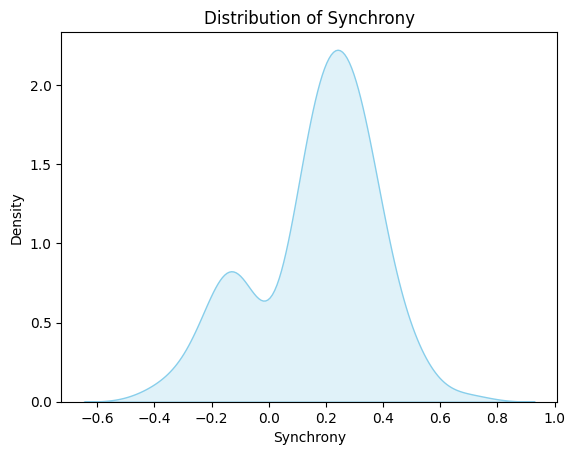

In [ ]:
# Density curve of the target Synchrony
sns.kdeplot(imputation_df_2['Synchrony'], fill=True, color='skyblue')

plt.title(f'Distribution of Synchrony')
plt.xlabel('Synchrony')
plt.ylabel('Density')
plt.show()

In [ ]:
# Perform the Anderson-Darling test for bimodality
Synchrony_nonan = imputation_df_2['Synchrony'].dropna()
Synchrony_nonan = pd.to_numeric(Synchrony_nonan, errors='coerce')
test_statistic, critical_values, significance_levels = anderson(Synchrony_nonan)

# Interpret the results
print(f"Test statistic: {test_statistic:.4f}")
print(f"Critical values at significance levels (%): {critical_values}")
print(f"Corresponding significance levels:      {significance_levels}")

# Check if the distribution is potentially bimodal
if test_statistic > critical_values[4]:
    print("The distribution is most likely bimodal.")
else:
    print("The distribution is probably not bimodal.")

Test statistic: 2.8463
Critical values at significance levels (%): [0.56  0.638 0.765 0.893 1.062]
Corresponding significance levels:      [15.  10.   5.   2.5  1. ]
The distribution is most likely bimodal.


Knowing that the distribution of `Synchrony` is most likely bimodal, it will be necessary to perform Multiple imputation for continuous variables with the use of predictive-mean matching (PMM) (Austin et al., 2021).

"Morris et al. suggest that identifying the 10 closest subjects without missing data performs well" (Austin et al, 2021).

In [ ]:
num_datasets=13   # rule of thumb of percentage of particiants with any missing data
num_iterations=12 # a number between 5 and 20
num_candidates=10 # number of optimal closest subjects

### Miceforest Imputation

In [ ]:
# Set up the PMM
scheme_mmc = mean_match_shap.copy()
scheme_mmc.set_mean_match_candidates(num_candidates)

# Create kernel
kernel_meanmatch_group = mf.ImputationKernel(
                              imputation_df_2.drop(['group_number', 'subjectID_1', 'subjectID_2'], axis=1), # remove ID features
                              mean_match_scheme=scheme_mmc,
                              datasets=num_datasets,
                              save_all_iterations=True,
                              random_state=456,
                              )

# Tune the parameters
optimal_parameters_group, loss = kernel_meanmatch_group.tune_parameters(
                              dataset=8, # a random dataset
                              nfold=17,
                              verbose=True,
                              random_state=456
)

Initialized logger with name tune: 5
Group_CCF_I_Mean | 0 - 1 - 2 - 3 - 4 - 
Synchrony | 0 - 1 - 2 - 3 - 4 - 


In [ ]:
# Display the best parameters and loss for Synchrony
print('Synchrony')
print(optimal_parameters_group[17])
print(f'Average out of fold cross-validation loss: {loss[17]}')

Synchrony
{'boosting': 'gbdt', 'num_iterations': 67, 'max_depth': 8, 'num_leaves': 8, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.4201352843642502, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7565098729345135, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'learning_rate': 0.02, 'cat_smooth': 13.924705831702298}
Average out of fold cross-validation loss: 0.0346714917782207


In [ ]:
# Run the MICE algorithm for
kernel_meanmatch_group.mice(num_iterations,
                           variable_parameters=optimal_parameters_group,
                           verbose=True)

Initialized logger with name mice 1-12
Dataset 0
1  | Group_CCF_I_Mean | Synchrony
2  | Group_CCF_I_Mean | Synchrony
3  | Group_CCF_I_Mean | Synchrony
4  | Group_CCF_I_Mean | Synchrony
5  | Group_CCF_I_Mean | Synchrony
6  | Group_CCF_I_Mean | Synchrony
7  | Group_CCF_I_Mean | Synchrony
8  | Group_CCF_I_Mean | Synchrony
9  | Group_CCF_I_Mean | Synchrony
10  | Group_CCF_I_Mean | Synchrony
11  | Group_CCF_I_Mean | Synchrony
12  | Group_CCF_I_Mean | Synchrony
Dataset 1
1  | Group_CCF_I_Mean | Synchrony
2  | Group_CCF_I_Mean | Synchrony
3  | Group_CCF_I_Mean | Synchrony
4  | Group_CCF_I_Mean | Synchrony
5  | Group_CCF_I_Mean | Synchrony
6  | Group_CCF_I_Mean | Synchrony
7  | Group_CCF_I_Mean | Synchrony
8  | Group_CCF_I_Mean | Synchrony
9  | Group_CCF_I_Mean | Synchrony
10  | Group_CCF_I_Mean | Synchrony
11  | Group_CCF_I_Mean | Synchrony
12  | Group_CCF_I_Mean | Synchrony
Dataset 2
1  | Group_CCF_I_Mean | Synchrony
2  | Group_CCF_I_Mean | Synchrony
3  | Group_CCF_I_Mean | Synchrony
4  | Gr

In [ ]:
# Display the settings
kernel_meanmatch_group


              Class: ImputationKernel
           Datasets: 13
         Iterations: 12
       Data Samples: 153
       Data Columns: 30
  Imputed Variables: 2
save_all_iterations: True

### Diagnostic Plotting

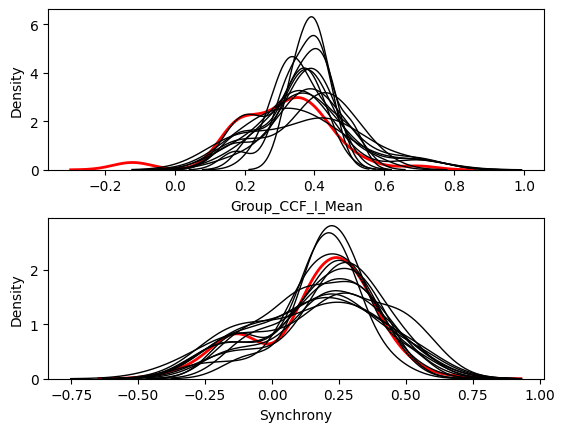

In [ ]:
# Distributions
kernel_meanmatch_group.plot_imputed_distributions(variables=['Synchrony', 'Group_CCF_I_Mean'], hspace=0.3)

The distribution of imputed data for Group_CFF_I_Mean roughly follows the distribution of real data, with low imputation accuracy for the multimodality.
Synchrony imputations follow the distribution of real data fairly well. Bimodality is represented, although a little flattened by some imputations, pushing the distribution to center around the global maximum.

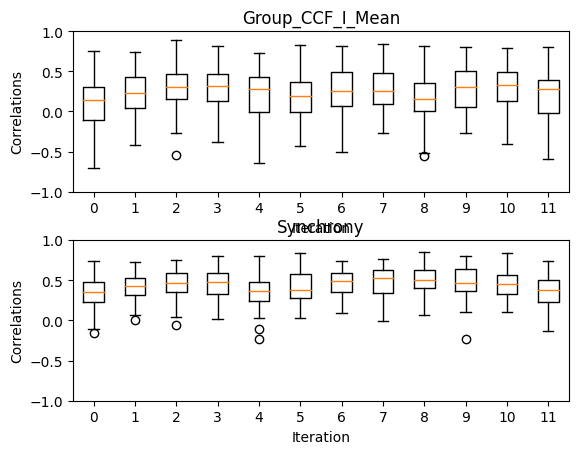

In [ ]:
# Correlation between datasets
kernel_meanmatch_group.plot_correlations(variables=['Synchrony', 'Group_CCF_I_Mean'], hspace=0.3)

No major improvement in correlation seems to be visible across iterations.

The various imputations (i.e. the 13 datasets) are slightly correlated for Group_CCF_I_mean. The Synchrony imputations show higher correlations of around 0.5, giving greater confidence in the accuracy of the imputations.

### Mean aggregation of all the datasets et data wrangling

In [ ]:
# Aggregate all the datasets by the mean
sum_df = kernel_meanmatch_group.complete_data(0)[['Synchrony', 'Group_CCF_I_Mean']]
for i in range(1, 13):
  sum_df = sum_df + kernel_meanmatch_group.complete_data(i)[['Synchrony', 'Group_CCF_I_Mean']]
imputed_df_group = sum_df/13

In [ ]:
# Calculate the mean of the three imputed values of Group_CCF_I_Mean, per group
idx=0
for i in range(5):
  # Identify the first index of missing data in mean_col
  part_of_df = imputation_df_2['Group_CCF_I_Mean'].iloc[idx:]
  idx = part_of_df.isnull().idxmax()
  mean_imputed = imputed_df_group['Group_CCF_I_Mean'].iloc[idx:idx+3].mean()
  # Replace missing data with the mean of 'value_col' values
  df_imputed.loc[idx, 'Group_CCF_I_Mean'] = mean_imputed
  df_imputed.loc[idx+1, 'Group_CCF_I_Mean'] = mean_imputed
  df_imputed.loc[idx+2, 'Group_CCF_I_Mean'] = mean_imputed
  idx = idx+3

In [ ]:
# Synchrony in pair
# Imputation of the ID and the synchrony to follow the same pattern for every sample
for i in range (0, len(df_imputed), 3):
  # Define the three participants ID
  part1 = df_imputed['subjectID'].iloc[i]
  part2 = df_imputed['subjectID'].iloc[i+1]
  part3 = df_imputed['subjectID'].iloc[i+2]
  synchr12 = imputed_df_group['Synchrony'].iloc[i]
  synchr23 = imputed_df_group['Synchrony'].iloc[i+1]
  synchr31 = imputed_df_group['Synchrony'].iloc[i+2]

  # Define pairs for partner 1 (i)
  df_imputed.loc[i, 'Synchrony1_with'] = part2
  df_imputed.loc[i, 'Synchrony1'] = synchr12
  df_imputed.loc[i, 'Synchrony2_with'] = part3
  df_imputed.loc[i, 'Synchrony2'] = synchr31

  # Define pairs for partner 2 (i+1)
  df_imputed.loc[i+1, 'Synchrony1_with'] = part3
  df_imputed.loc[i+1, 'Synchrony1'] = synchr23
  df_imputed.loc[i+1, 'Synchrony2_with'] = part1
  df_imputed.loc[i+1, 'Synchrony2'] = synchr12

  # Define pairs for partner 3 (i+2)
  df_imputed.loc[i+2, 'Synchrony1_with'] = part1
  df_imputed.loc[i+2, 'Synchrony1'] = synchr31
  df_imputed.loc[i+2, 'Synchrony2_with'] = part2
  df_imputed.loc[i+2, 'Synchrony2'] = synchr23

<Axes: >

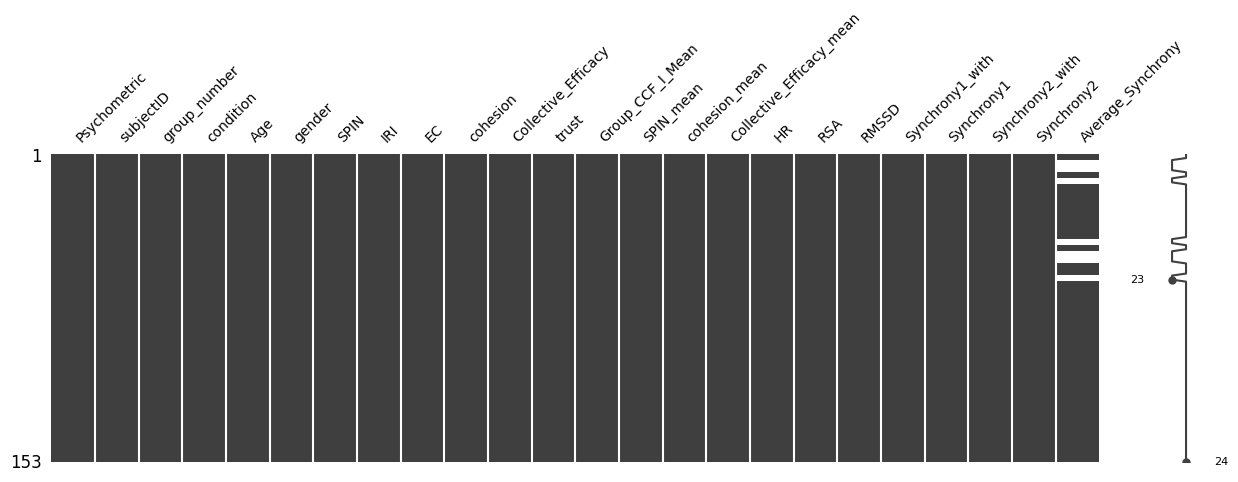

In [ ]:
msno.matrix(df_imputed, figsize=(15,4), fontsize=10)

## Last group feature: Average_Synchrony

In [ ]:
df_imputed['Average_Synchrony'] = (df_imputed['Synchrony1'] + df_imputed['Synchrony2']) / 2

<Axes: >

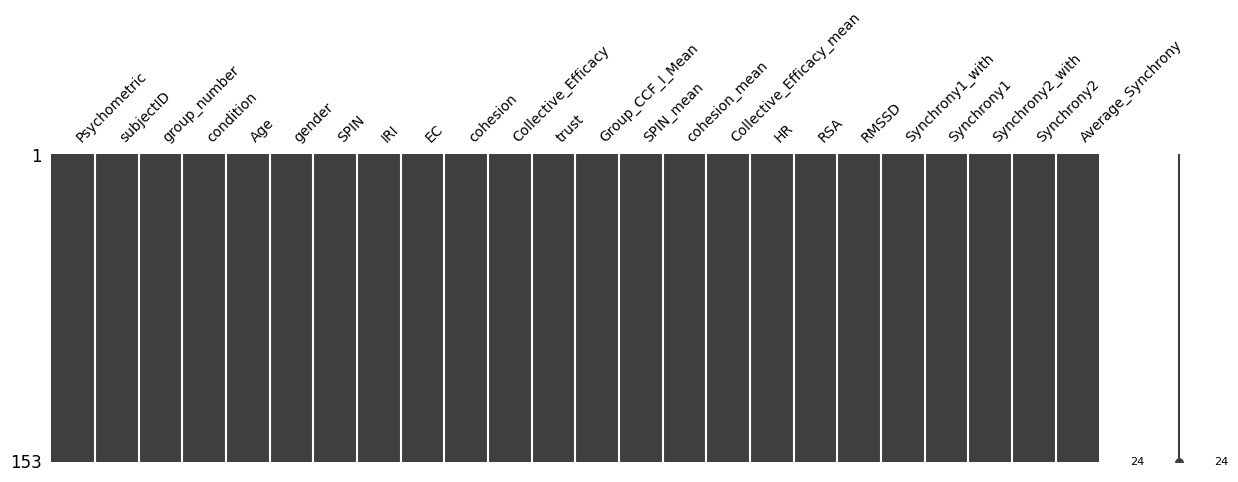

In [ ]:
msno.matrix(df_imputed, figsize=(15,4), fontsize=10)

# EXPORTATION

In [ ]:
# Export df_imputation to .csv file
file_path = '/content/Music_imputation.csv'
df_imputed.to_csv(file_path, index=False)